In [1]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [2]:
spark= SparkSession.builder.getOrCreate()

In [3]:
df= spark.read.csv("hack_data.csv", header= True, inferSchema= True)

In [4]:
df.show(2)

+-----------------------+-----------------+---------------+-----------------+---------------+--------------------+----------------+
|Session_Connection_Time|Bytes Transferred|Kali_Trace_Used|Servers_Corrupted|Pages_Corrupted|            Location|WPM_Typing_Speed|
+-----------------------+-----------------+---------------+-----------------+---------------+--------------------+----------------+
|                    8.0|           391.09|              1|             2.96|            7.0|            Slovenia|           72.37|
|                   20.0|           720.99|              0|             3.04|            9.0|British Virgin Is...|           69.08|
+-----------------------+-----------------+---------------+-----------------+---------------+--------------------+----------------+
only showing top 2 rows



In [5]:
df.columns

['Session_Connection_Time',
 'Bytes Transferred',
 'Kali_Trace_Used',
 'Servers_Corrupted',
 'Pages_Corrupted',
 'Location',
 'WPM_Typing_Speed']

In [6]:
df.describe().toPandas()

,summary,Session_Connection_Time,Bytes Transferred,Kali_Trace_Used,Servers_Corrupted,Pages_Corrupted,Location,WPM_Typing_Speed
0,count,334,334,334,334,334,334,334
1,mean,30.008982035928145,607.2452694610777,0.5119760479041916,5.258502994011977,10.838323353293413,None,57.342395209580864
2,stddev,14.088200614636158,286.33593163576757,0.5006065264451406,2.30190693339697,3.06352633036022,None,13.41106336843464
3,min,1.0,10.0,0,1.0,6.0,Afghanistan,40.0
4,max,60.0,1330.5,1,10.0,15.0,Zimbabwe,75.0


In [7]:
feature_cols=['Session_Connection_Time',
 'Bytes Transferred',
 'Kali_Trace_Used',
 'Servers_Corrupted',
 'Pages_Corrupted',
 'WPM_Typing_Speed'    
]

In [8]:
assembler= VectorAssembler(inputCols= feature_cols, outputCol='features')

In [9]:
final= assembler.transform(df)

In [10]:
scaler= StandardScaler(inputCol= 'features', 
                       outputCol= 'scaled_feat',
                       withStd= True,
                       withMean= False)

In [11]:
scaled_model= scaler.fit(final)

In [12]:
cluster_df= scaled_model.transform(final)

In [13]:
evaluator= ClusteringEvaluator(predictionCol= 'prediction',
                          featuresCol= 'scaled_feat',
                          metricName= 'silhouette',
                          distanceMeasure= 'squaredEuclidean')

In [14]:
silhouette_score= []
print('Silhoutte scores for K Means Clustering')
for k in range(2,10):
    kmeans_algo= KMeans(featuresCol= 'scaled_feat', k=k)
    kmeans_fit= kmeans_algo.fit(cluster_df)
    output= kmeans_fit.transform(cluster_df)
    score= evaluator.evaluate(output)
    silhouette_score.append(score)
    print(f"K={k}\t{round(score,2)}")

Silhoutte scores for K Means Clustering
K=2	0.82
K=3	0.76
K=4	0.72
K=5	0.6
K=6	0.56
K=7	0.55
K=8	0.45
K=9	0.51


There are 2 hackers (highly likely)

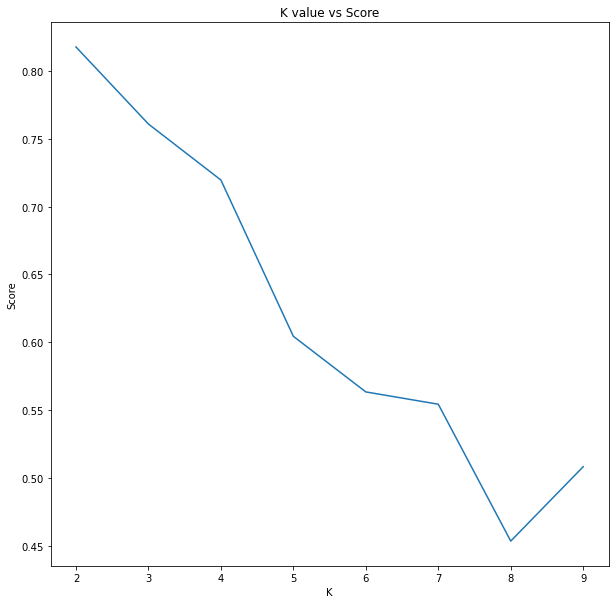

In [15]:
fig, ax= plt.subplots(1,1,figsize=(10,10))
ax.plot(range(2,10), silhouette_score)
ax.set_xlabel("K")
ax.set_ylabel("Score")
ax.set_title("K value vs Score");